In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import pickle
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC

%matplotlib inline

DATASET1_NAME = "spotify_songs.csv"
DATASET2_NAME = "lyrics-data.csv"
DATASET3_NAME = "artists-data.csv"

In [2]:
#dataset master repo: https://github.com/ashjames/Pegi-dataset
# NOTA: il titolo nominato "Moss" aveva una data malformata -0018 al posto di 2018- 
# è stato modificato manualmente sul dataset essendo un caso singolo
import os.path
if (not os.path.exists(DATASET1_NAME) or not os.path.exists(DATASET2_NAME) or not os.path.exists(DATASET3_NAME)):
    raise FileNotFoundError("ERROR: One or more datasets missing!")

In [3]:
#pd.set_option('display.max_columns', 500)
df_spot = pd.read_csv("spotify_songs.csv")
df_2 = pd.merge(pd.read_csv(DATASET2_NAME), pd.read_csv(DATASET3_NAME), left_on="ALink", right_on="Link")

In [4]:
df_spot.head()

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,1srJQ0njEQgd8w4XSqI4JQ,Trip,2001-01-01,Pinoy Classic Rock,37i9dQZF1DWYDQ8wBxd7xt,...,-10.068,1,0.0236,0.27900,0.01170,0.0887,0.566,97.091,235440,tl
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,...,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,...,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,...,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,...,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en


In [69]:
df_2.head()

NameError: name 'df_2' is not defined

In [70]:
df_eng = df_spot[df_spot["language"] == "en"]
df2_eng = df_2[df_2["Idiom"] == "ENGLISH"]

NameError: name 'df_spot' is not defined

In [71]:
len(df2_eng)

124230

In [8]:
#df_end_song_genre = df_eng.
df_eng = df_eng.loc[:, ["lyrics", "playlist_genre"]]
df2_eng = df2_eng.loc[:, ["Lyric", "Genre"]]

df_eng.rename(columns={"playlist_genre":"genre"}, inplace=True)
df2_eng.rename(columns={"Lyric":"lyrics", "Genre":"genre"}, inplace=True)

In [108]:
df = df_eng.append(df2_eng)
#del df_eng
#del df2_eng
#del df_spot
#del df_2

In [109]:
print(df.shape)
print(df.nunique())

(139635, 2)
lyrics    99834
genre        12
dtype: int64


In [110]:
df["lyrics"] = df["lyrics"].str.lower();
df["genre"] = df["genre"].str.lower();
print(df.nunique())

lyrics    99777
genre        10
dtype: int64


In [111]:
df = df.drop_duplicates(subset="lyrics")
print(df.shape)
print(df.nunique())

(99777, 2)
lyrics    99777
genre        10
dtype: int64


In [113]:
pd.set_option('display.max_rows', 1000)
#pd.set_option('display.max_colwidth', 100)
#df[df.duplicated(subset="lyrics")][:1000]
#df[df['lyrics'].str.contains("mujer")]

#Controllo testi particolarmente corti o lunghi
#Testi corti: molti incompleti, alcuni sono solo indicazione del fatto che la traccia è strumentale

df_sorted = df
df_sorted.index = df['lyrics'].str.len()
df_sorted = df_sorted.sort_index(ascending=False).reset_index(drop=True)
df_sorted["lyrics"].sort_index(ascending=False)[:20]

99776               no lyrics
99775               play nice
99774               beautiful
99773            don't lyrics
99772         improvised song
99771        all systems down
99770        the son. the sun
99769       instrumental song
99768       kick it like this
99767       instrumental only
99766       without your love
99765       (one, two, three)
99764      who told you how?.
99763      that beat is fire!
99762     (instrumental song)
99761     smooth that out now
99760     written by jay kay.
99759    instrumental only...
99758    acapella, no lyrics.
99757    (instrumental track)
Name: lyrics, dtype: object

In [117]:
#I testi molto lunghi sembrano per la maggior parte a posto, ma alcuni per esempio indicano spartiti musicali per
#la maggior parte

#Mostrandone di più si nota anche come alcuni abbiano delle annotazioni nel testo, ad esempio "[laughs]" 
#per indicare che il cantante sta ridendo, oppure (feat. -elenco nomi-) -> questi pattern sono 
#intercettabili tramite regex, ma ho rilevato anche altre irregolarità più difficili da rintracciare

#pattern "intro -qualsiasi cosa- ."

#In genrale gli elementi fra parentesi quadre sembrano note aggiuntive, quelli fra tonde possono essere però 
#voci in sottofondo

#Molti carattari numerici o non alfabetici
df_sorted["lyrics"].sort_index(ascending=True)[:10]

0    e|-----------------------------------------------------------------------|. b|--------------10-1...
1    e-------5-7-----7-|-8-----8-2-----2-|-0---------0-----|-----------------|. b-----5-----5-----|--...
2    notation legend.-. / = slide. = palm mute. b = bend to note («=half, f=full, f«=one & a half, et...
3    words and music by f.iommi, t.butler, w.ward, j.osbourn. transcribed by andy aledort. d5 e5. x 5...
4    na workin' on a weekend like usual way off in the deep end like usual niggas swear they passed u...
5    it's funny, the shit i put on this song ain't gon' sound nothin' like the shit we was just doin'...
6    yeah i'm home now, it's over now, so... yeah she got a thing for chanel vintage that dropped bef...
7    na astro, yeah sun is down, freezin' cold that's how we already know, winter's here my dawg woul...
8    wheezy outta here hot, hot, hot, hot hot, hot, hot, hot hot, hot, hot, hot hot, hot, hot, hot ev...
9    yo, sing this shit, are y'all fuckin' dumb? eterna

In [118]:
del df_sorted

In [149]:
#Diamo quindi un'occhiata alle lunghezze, per vedere se si può scremare 
#facilmente parte del dataset rimanendo nei valori medi

len = df["lyrics"].str.len()
len.describe()

#Vediamo come prevedibile una enorme deviazione e differenza fra i testi più corti e quelli più lunghi

count    99777.000000
mean      1511.793199
std       1111.413659
min          9.000000
25%        868.000000
50%       1241.000000
75%       1815.000000
max      64047.000000
Name: lyrics, dtype: float64

In [150]:
#Realisticamente, i testi sembrano essere fra i 1000 e 3000 caratteri
np.quantile(lengths, 0.5), np.quantile(lengths, 0.95)

(1241.0, 3438.199999999997)

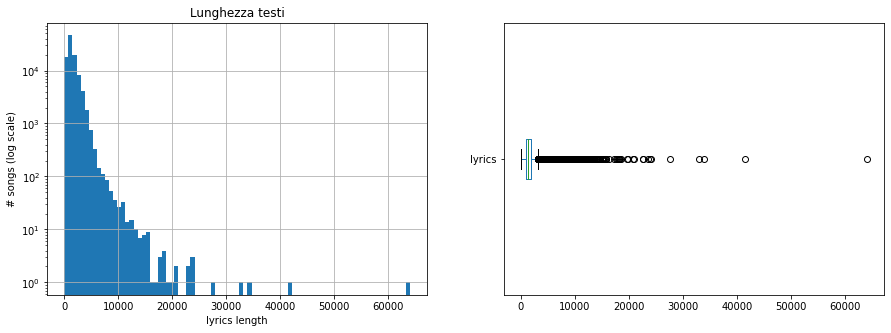

In [152]:
plt.figure(figsize=(15,5))

# Visualizziamo i dati (prolly elimina primo grafico)
plt.subplot(121)
plt.title("Lunghezza testi")
plt.xlabel("lyrics length")
plt.ylabel("# songs (log scale)")
len.hist(bins=85, log=True);

plt.subplot(122)
len.plot.box(vert=False);

In [153]:
#NOTA: DOPO AVER SCREMATO CONTROLLA DISTRIBUZIONE GENERI

In [146]:
len = df_filtered["lyrics"].str.len()
len.describe()

,lyrics,genre
lyrics,,
2287,"na yeah, spyderman and freeze in full effect uh-huh you ready, ron? i'm ready you ready, biv? i'...",r&b
2287,you got me some type of way (hmm) ain't used to feelin' this way (mmm-mmm) i do not know what to...,pop
2287,"you! you're losing, you're losing, you're losing, you're losing your mind hey you! you're losing...",edm
2287,not i'm not the type to just act like i know. puttin on an angle putting on a show. speaking on ...,rock
2287,this is a song about spike. he is a bad ass guy. who just happens to be. a really good friend of...,rock


In [108]:
df_eng['playlist_genre'].value_counts()

pop      3739
rock     3388
r&b      3161
rap      2502
edm      1758
latin     857
Name: playlist_genre, dtype: int64

In [109]:
df_eng['playlist_subgenre'].value_counts()

indie poptimism              1260
southern hip hop             1137
neo soul                      990
hard rock                     922
new jack swing                880
urban contemporary            878
classic rock                  873
post-teen pop                 873
electropop                    835
permanent wave                828
dance pop                     771
album rock                    765
gangster rap                  667
progressive electro house     566
pop edm                       524
hip hop                       494
hip pop                       413
electro house                 400
latin hip hop                 364
tropical                      306
big room                      268
trap                          204
latin pop                     177
reggaeton                      10
Name: playlist_subgenre, dtype: int64

In [110]:
#usa coutvectorizer e guarda i termini meno comuni: ce ne sono alcuni con caratteri orientali


#Quindi di seguito pulisco

In [111]:
import re
regex_keep = re.compile('[^a-zA-Z ]')

def clean_text(text):
    return regex_keep.sub('', text)

df_eng["lyrics"] = df_eng["lyrics"].apply(lambda x: clean_text(x));

In [112]:
Gx_t, Gx_v, Gy_t, Gy_v = train_test_split(df_eng['lyrics'], df_eng['playlist_genre'], random_state=42, test_size=1/3)

In [113]:
#from https://stackoverflow.com/questions/16078015/list-the-words-in-a-vocabulary-according-to-occurrence-in-a-text-corpus-with-sc
def get_popular_words(vect, vect_fit):
    sum_words = cv_fit.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    return sorted(words_freq, key = lambda x: x[1], reverse=True)

In [114]:
cv = CountVectorizer(stop_words=nltk.corpus.stopwords.words("english"))
cv_fit = cv.fit_transform(Gx_t)
get_popular_words(cv, cv_fit)[:10]

[('im', 49845),
 ('dont', 34542),
 ('like', 32885),
 ('know', 30252),
 ('love', 30073),
 ('yeah', 29572),
 ('oh', 27151),
 ('got', 24652),
 ('get', 21128),
 ('go', 18133)]

In [115]:
#Considero n-gram

...

#Anche con 3-gram, la maggior parte sono ripetizioni
#considereremo
cv = CountVectorizer(stop_words=nltk.corpus.stopwords.words("english"), ngram_range=(2,2))
cv_fit = cv.fit_transform(Gx_t)
get_popular_words(cv, cv_fit)[:10]

[('oh oh', 8193),
 ('yeah yeah', 6516),
 ('dont know', 4002),
 ('love love', 3142),
 ('dont wanna', 2761),
 ('let go', 2732),
 ('na na', 2685),
 ('la la', 2650),
 ('im gonna', 2238),
 ('ooh ooh', 2153)]

In [116]:
#Potresti provare anche Perceptron

In [183]:
from nltk import stem, word_tokenize
stemmer = stem.PorterStemmer()
def tokenize_stem(words):
    words.lower()
    return [stemmer.stem(w) for w in word_tokenize(words) if w not in stop_words]
def tokenize(words):
    words.lower()
    return [w for w in word_tokenize(words) if w not in stop_words]

In [184]:
from sklearn.pipeline import Pipeline
#Prepara grid
stop_words = nltk.corpus.stopwords.words("english")

grid = {
    "model__C" : [.1, .5, 1, 3],
    "tokenizer__tokenizer" : [None, tokenize_stem],
    "tokenizer__min_df" : [10, 30, 50, 100],
    "model__penalty": ["l1", "l2"],
    "model__class_weight": ["balanced", None]
}

#Prepara pipeline
logreg = Pipeline([
    ("tokenizer", TfidfVectorizer(tokenizer = tokenize, min_df=50)),
    ("model", LogisticRegression(solver = "saga", random_state = 12, C=.5, penalty="l2" , n_jobs=-1))
])

logreg.fit(Gx_t, Gy_t);
logreg.score(Gx_v, Gy_v)

#gs = GridSearchCV(logreg, param_grid=grid)
#gs.fit(Gx_t, Gy_t)
#gs.score(Gx_v, Gy_v)
#cross validate

0.5076923076923077

In [185]:
logreg.score(Gx_t, Gy_t)

0.5962999026290166

In [186]:
def get_k_words(model, vectorizer, best=True, k=15):
    """Get the k best or worst words based on the weight assigned by a model.
    
       Parameters:
         - model: the model whose coefficients have to be used
         - vectorizer: the vectorizer used by the model whose bag of words has to be evaluated
         - best: if True gets the k best words, otherwise the k worst
         - k: the number of words to be returned
         
       Returns:
         A pandas dataframe containing the words and their corresponding weight."""
    return pd.DataFrame(model.coef_, 
                        columns=vectorizer.get_feature_names()).T.sort_values(by=0, ascending=not best).head(k)

In [187]:
headers = df_eng["playlist_genre"].unique()
headers

array(['rock', 'r&b', 'pop', 'edm', 'rap', 'latin'], dtype=object)

In [188]:
df = get_k_words(logreg.named_steps["model"],
            logreg.named_steps["tokenizer"], k=10);
df.columns = headers
pd.set_option('display.max_rows', 500)
#df["edm"].sort_values(ascending=False)

In [189]:
song = ["Yeah I've been tryna call I've been on my own for long enough Maybe you can show me how to love, maybe I'm going through withdrawals You don't even have to do too much You can turn me on with just a touch, baby I look around and Sin City's cold and empty (Oh) No one's around to judge me (Oh) I can't see clearly when you're gone I said, ooh, I'm blinded by the lights No, I can't sleep until I feel your touch I said, ooh, I'm drowning in the night Oh, when I'm like this, you're the one I trust Hey, hey, hey I'm running out of time 'Cause I can see the sun light up the sky So I hit the road in overdrive, baby, oh The city's cold and empty (Oh) No one's around to judge me (Oh) I can't see clearly when you're gone I said, ooh, I'm blinded by the lights No, I can't sleep until I feel your touch I said, ooh, I'm drowning in the night Oh, when I'm like this, you're the one I trust I'm just walking by to let you know (By to let you know) I can never say it on the phone (Say it on the phone) Will never let you go this time (Ooh) I said, ooh, I'm blinded by the lights No, I can't sleep until I feel your touch Hey, hey, hey Hey, hey, hey I said, ooh, I'm blinded by the lights No, I can't sleep until I feel your touch"];

In [190]:
logreg.predict(song)

array(['pop'], dtype=object)